# 소비자 데이터 기반 소비 예측 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
sns.set_theme()

In [3]:
SEED = 22

In [4]:
os.chdir('C:/Users/Jaesu/github_desktop/Dacon-Basic/소비자-소비-예측')

In [704]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

|변수 이름|세부 사항|
|:-:|:-:|
|id| 샘플 아이디|
|Year_Birth | 고객 생년월일|
|Education | 고객 학력|
|Marital_status | 고객 결혼 상태|
|Income | 고객 연간 가구 소득|
|Kidhome | 고객 가구의 자녀 수|
|Teenhome | 고객 가구의 청소년 수|
|Dt_Customer | 고객이 회사에 등록한 날짜|
|Recency | 고객의 마지막 구매 이후 일수|
|NumDealsPurchases | 할인된 구매 횟수|
|NumWebPurchases | 회사 웹사이트를 통한 구매 건수|
|NumCatalogPurchases | 카탈로그를 사용한 구매 수| 
|NumStorePurchases | 매장에서 직접 구매한 횟수|
|NumWebVisitsMonth | 지난 달 회사 웹사이트 방문 횟수|
|AcceptedCmp1| 고객이 첫 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0|
|AcceptedCmp2| 고객이 두 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0|
|AcceptedCmp3| 고객이 세 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0|
|AcceptedCmp4| 고객이 네 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0|
|AcceptedCmp5| 고객이 다섯 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0|
|Complain | 고객이 지난 2년 동안 불만을 제기한 경우 1, 그렇지 않은 경우 0|
|Response | 고객이 마지막 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0|
|target | 고객의 제품 총 소비량|

In [705]:
df.shape, test.shape

((1108, 22), (1108, 21))

In [706]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Dt_Customer          1108 non-null   object 
 8   Recency              1108 non-null   int64  
 9   NumDealsPurchases    1108 non-null   int64  
 10  NumWebPurchases      1108 non-null   int64  
 11  NumCatalogPurchases  1108 non-null   int64  
 12  NumStorePurchases    1108 non-null   int64  
 13  NumWebVisitsMonth    1108 non-null   int64  
 14  AcceptedCmp3         1108 non-null   int64  
 15  AcceptedCmp4         1108 non-null   i

`-` 결측치는 없다

## 데이터 전처리 및 파생변수 생성

`-` Dt_Customer(고객이 회사에 등록한 날짜) 변수가 문자형으로 되어있다

`-` 이를 날짜 형식으로 바꿔주자

In [707]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

`-` 연, 월, 일을 새로운 변수로 만들자

In [708]:
df['Dt_Customer_Year'] = df['Dt_Customer'].dt.year
df['Dt_Customer_Month'] = df['Dt_Customer'].dt.month
df['Dt_Customer_Day'] = df['Dt_Customer'].dt.day

`-` `Dt_Customer` 변수는 쓸모를 다했으니 drop 하겠다

In [709]:
df.drop('Dt_Customer', axis=1, inplace=True)

`-` `Year_Birth` 변수를 이용하여 나이를 계산하자

In [710]:
df['Age'] = 2022 - df['Year_Birth']

<AxesSubplot:>

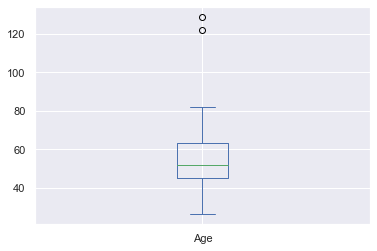

In [711]:
df['Age'].plot.box()

`-` 100살을 넘어가는 2명은 이상점으로 간주하고 제거하겠다

In [712]:
df.drop('Year_Birth', axis=1, inplace=True)

In [713]:
df = df.query('Age < 100').reset_index().drop('index', axis=1)

`-` 캠페인에서 한 번이라도 수락했으면 그렇지 않은 사람과 차이가 있을 것 같다

`-` 이를 구분하기 위한 새로운 피쳐를 만들자

`-` 캠페인에 한 번 참여한 사람과 여러번 참여한 사람도 구분할까 했는데

`-` 2번보다 많이 참여한 사람이 100명도 안되서 안하기로 했다(2번: 51, 3번: 17, 4번: 6)

In [714]:
df['AcceptedCmpAny'] = (df['AcceptedCmp1']
                         + df['AcceptedCmp2'] 
                         # + df['AcceptedCmp3'] 
                         + df['AcceptedCmp4'] 
                         + df['AcceptedCmp5'] 
                         # + df['Response']
                        ).apply(lambda x: 1 if x >= 1 else 0) ## Response는 따로 취급할지 고민

`-` `NumWebPurchases`, `NumCatalogPurchases`, `NumStorePurchases`를 종합해서 전체 구매 횟수 변수를 생성하겠다

`-` 전체 구매 횟수에서 `NumDealsPurchases`만큼 제외하면 할인을 받지 않고 구매한 건수가 된다

In [715]:
df['TotalPurchases'] = df['NumStorePurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] ## 전체 구매 횟수
df['NotSalePurchases'] = df['TotalPurchases'] - df['NumDealsPurchases'] ## 할인 받지 않은 구매 횟수

`-` 할인 받지 않은 구매 횟수에 음수가 있어서 이를 제거하겠다

In [716]:
df = df.query('NotSalePurchases >= 0').reset_index().drop('index', axis=1)

`-` 한편, 범주형 변수인데 수치로 인코딩된 변수가 있다

`-` 이를 범주형 변수로 만들어주겠다

`-` 하는 김에 문자형으로 인코딩된 변수도 카테고리형 변수로 만들어주겠다

`-` 자녀수 같은 변수는 가질 수 있는 값(많아봐야 보통은 3)이 한정되어 있으니 범주형 변수로 만들것이다

In [717]:
def feature_engineering(df_) -> pd.DataFrame:
    df = df_.copy()

    ## 현재 나이
    df['age'] = 2022 - df['Year_Birth']
    df.drop('Year_Birth', axis=1, inplace=True)
    
    ## 캠페인 수락
    df['AcceptedCmpAny'] = (df['AcceptedCmp1'] 
                             + df['AcceptedCmp2'] 
                             # + df['AcceptedCmp3'] 
                             + df['AcceptedCmp4'] 
                             + df['AcceptedCmp5'] 
                             # + df['Response']
                            ).apply(lambda x: 1 if x >= 1 else 0)
    
    ## 구매 횟수
    df['TotalPurchases'] = df['NumStorePurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] ## 전체 구매 횟수
    df['NotSalePurchases'] = df['TotalPurchases'] - df['NumDealsPurchases'] ## 할인 받지 않은 구매 횟수
    
    ## 날짜
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
    df['Dt_Customer_Year'] = df['Dt_Customer'].dt.year
    df['Dt_Customer_Month'] = df['Dt_Customer'].dt.month
    df['Dt_Customer_Day'] = df['Dt_Customer'].dt.day
    df.drop('Dt_Customer', axis=1, inplace=True)
    
    return df

In [718]:
def move_target_end(df) -> None:
    """target column을 마지막 column으로 이동시키는 함수"""
    target = df['target']
    df.drop('target', axis=1, inplace=True)
    df['target'] = target

In [719]:
def to_int(df) -> None:
    categorical_feature = ['Kidhome', 'Teenhome', 
                           'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmpAny',
                           'Complain', 'Response']
    
    for feature in categorical_feature:
        df[feature] = df[feature].astype('int')

In [720]:
def to_category(df) -> None:
    categorical_feature = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 
                           'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmpAny', 
                           'Complain', 'Response']
    
    for feature in categorical_feature:
        df[feature] = df[feature].astype('category')

In [721]:
move_target_end(df)

In [722]:
to_category(df)

- test data

In [723]:
test = feature_engineering(test)

In [724]:
to_category(test)

## EDA

### 범주형 변수 시각화

In [109]:
def show_unique_counts(df_: pd.DataFrame, target: str = None) -> None:
    """ df의 변수 중에서 범주형 변수의 unique한 값의 개수를 시각화하는 함수"""
    df = df_.copy()
    df = df.dropna() ## 결측치 제거
    ## len(df.columns[(df.dtypes == 'object') | (df.dtypes == 'category')])의 결과를 보고 적절한 shape을 수동으로 지정해야 한다
    ## ex: 결과값이 12이므로 4 X 3 크기의 figure를 만들자
    row, column = 4, 3
    fig, axs = plt.subplots(row, column, figsize=(15, 20))
    features = df.columns[(df.dtypes == 'object') | (df.dtypes == 'category')]
    
    for i, feature in enumerate(features):
        ax = axs[i // column][i % column]
        order = df_[feature].sort_values().unique() ## dropna() 때문에 사라진 범주가 있어서 삭제 전의 df_를 기준으로 order를 만듦
        if target is not None:
            gg = sns.histplot(data=df, y=feature, hue=target, multiple='stack', shrink=0.8, discrete=True, ax=ax)
        else:
            gg = sns.countplot(data=df, x=feature, ax=ax)
            
        # max_width = max([p.get_width() for p in gg.patches]) 
        # sns.move_legend(gg, 'lower right', title='income') ## target이 not None일 때 실행

        if target is not None:
            for j, p in enumerate(gg.patches):
                try:
                    condition = f'{feature} == "{order[j]}"'
                    aa = df.query(condition)['target'].value_counts()
                    success = '>50K' ## success는 수동으로 알맞게 지정해야 한다
                    text = np.round((100 * aa.to_dict().pop(success, 0) / sum(aa)), 2) ## text => (success) / sum(success, fail_1, fail_2, ..., fail_k) ---> target의 범주가 k+1개
                    gg.annotate('{:.2f}%'.format(text), (p.get_width() + 0.05*max_width, p.get_y() + 0.5*p.get_height() + 0.06)) ## text의 위치 조정
                except:
                    pass
                
    ## 남는 서브 플랏은 삭제하자
    for ax in axs: ## axs의 row
        for k in range(column): ## axs의 column
            if not ax[k].has_data(): 
                fig.delaxes(ax[k]) ## 남는 서브 플랏이니 삭제한다

    fig.suptitle("Categorical feature's Unique Counts\n\n", x=0.56, fontsize=25) ## default: x=0.5, y=0.98
    fig.tight_layout()

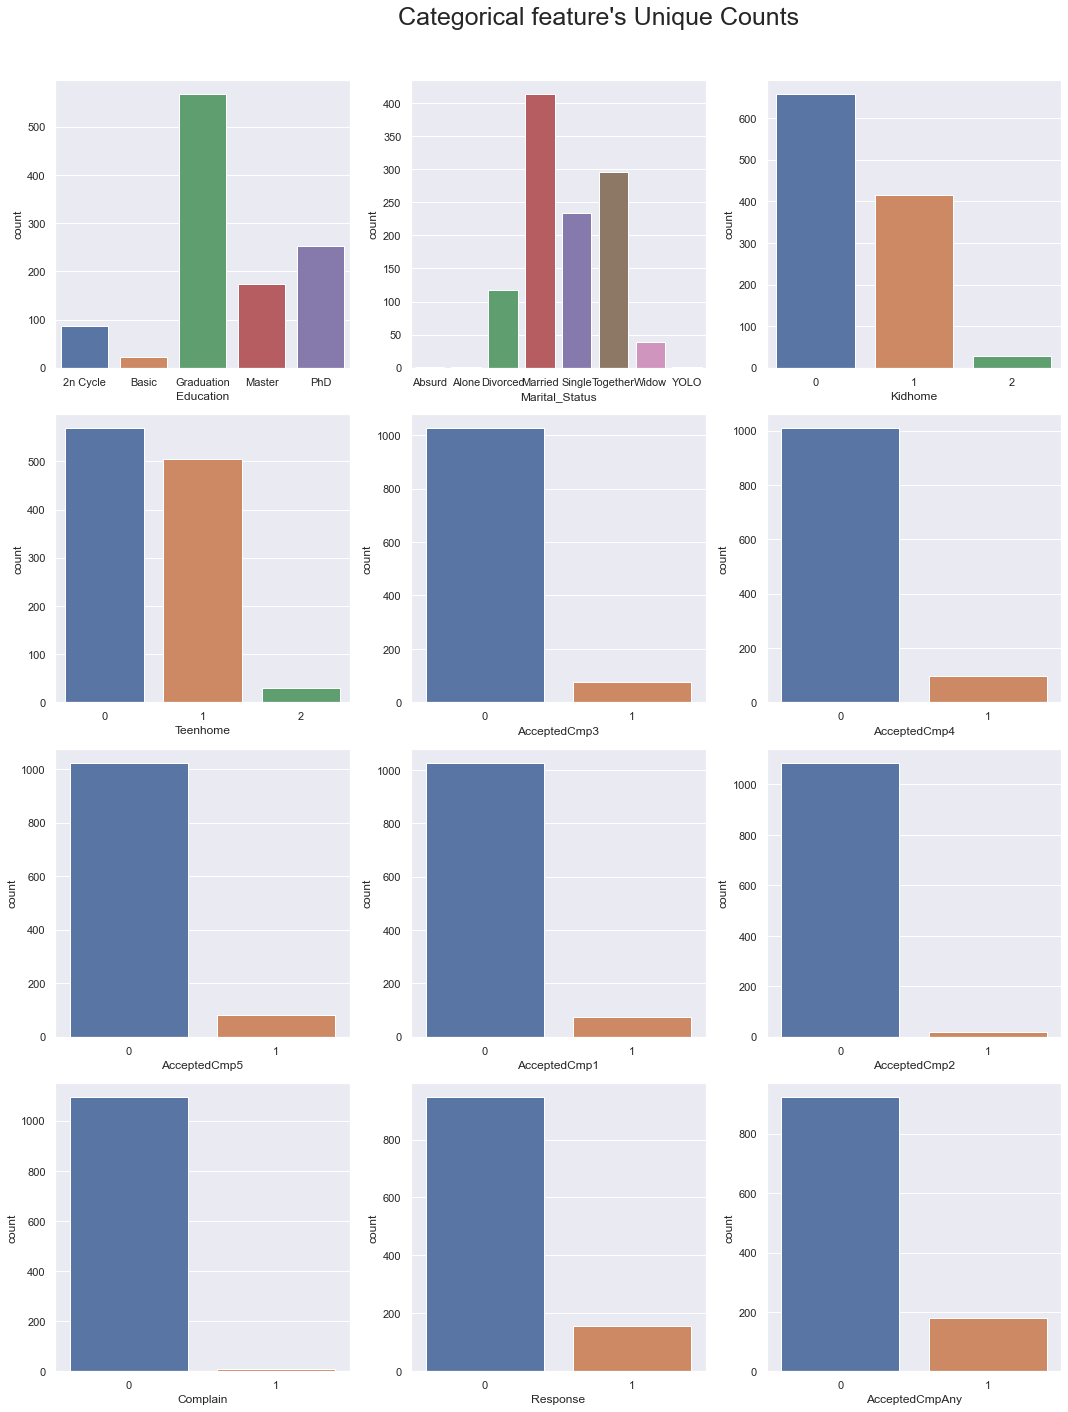

In [110]:
show_unique_counts(df)

`-` Marital_Status에서 'Alone', 'YOLO', 'Absurd'는 데이터가 극히 작고 Single에 범주에 포함되므로 single로 통합시켜 분석할 수도 있습니다

`-` Kidhome와 Teenhome에서 자녀 및 청소년을 2명둔 사람은 소수다

`-` 또한 Teenhome은 Kidhome에서 청소년인 경우만 집계한 것이기에 다중공선성 우려가 있다

`-` 청소년이냐 아니냐가 소비에 영향을 주지 않는다면 Teenhome은 쓰지 않아야 한다

`-` `AcceptedCmp 1~5`에서 보면 1(캠페인 참여)의 데이터가 매우 적다

`-` 하지만 마지막 캠페인에는 평상시보다 2배 이상의 인원이 참여했다(마지막이라서 그런건가?)

`-` Complain하는 사람은 없다 봐도 무방하다(1000명이 넘는 사람 중에서 10명 있음)

### 양적 변수 상관관계 시각화

In [442]:
def corr(df, condition, feature) -> tuple:
    corr0 = np.corrcoef(df.query(f'{condition} == 0')[feature], df.query(f'{condition} == 0')['target'])[1, 0]
    corr1 = np.corrcoef(df.query(f'{condition} == 1')[feature], df.query(f'{condition} == 1')['target'])[1, 0]
    return corr0, corr1

In [485]:
np.corrcoef(df['target'],  df['NotSalePurchases'] / (df['TotalPurchases'] + 25))

array([[1.        , 0.81339955],
       [0.81339955, 1.        ]])

In [454]:
corr(df, 'Teenhome', 'TotalPurchases')

(0.8151871722457366, 0.7887277424672872)

In [458]:
corr(df, 'Teenhome', 'Income')

(0.8358777143503738, 0.7074820317378256)

In [453]:
corr(df, 'Kidhome', 'TotalPurchases')

(0.654016669245944, 0.8611493637275882)

In [452]:
corr(df, 'Kidhome', 'NumCatalogPurchases')

(0.7006716122103526, 0.7969667104092605)

In [447]:
corr(df, 'Teenhome', 'NotSalePurchases')

(0.8263346695013486, 0.7565958996950773)

In [443]:
corr(df, 'Teenhome', 'NumStorePurchases')

(0.7233013384329586, 0.6682084038132615)

In [444]:
corr(df, 'Kidhome', 'NumStorePurchases')

(0.4908576294532472, 0.804014235519121)

In [445]:
corr(df, 'Teenhome', 'NumDealsPurchases')

(-0.2964838551630279, 0.20837970343859732)

In [446]:
corr(df, 'Teenhome', 'NumWebPurchases')

(0.5350049113709944, 0.7230201465041801)

In [111]:
def corr_heatmap(df_: pd.DataFrame) -> None:
    df = df_.copy()
    df = df.dropna() ## 결측치 제거
    
    features = [df.columns[i] for i, dtype in enumerate(df.dtypes) if dtype.name.find('int') != -1 or dtype.name.find('float') != -1] ## 숫자타입만 사용
    df_corr = df[features]
    corr = df_corr.corr(method='pearson')

    plt.figure(figsize=(16, 12))
    sns.heatmap(data = corr, annot=True, fmt='.2f', linewidths=.5, cmap='coolwarm')
    plt.title('Correlation between features', fontsize=25)

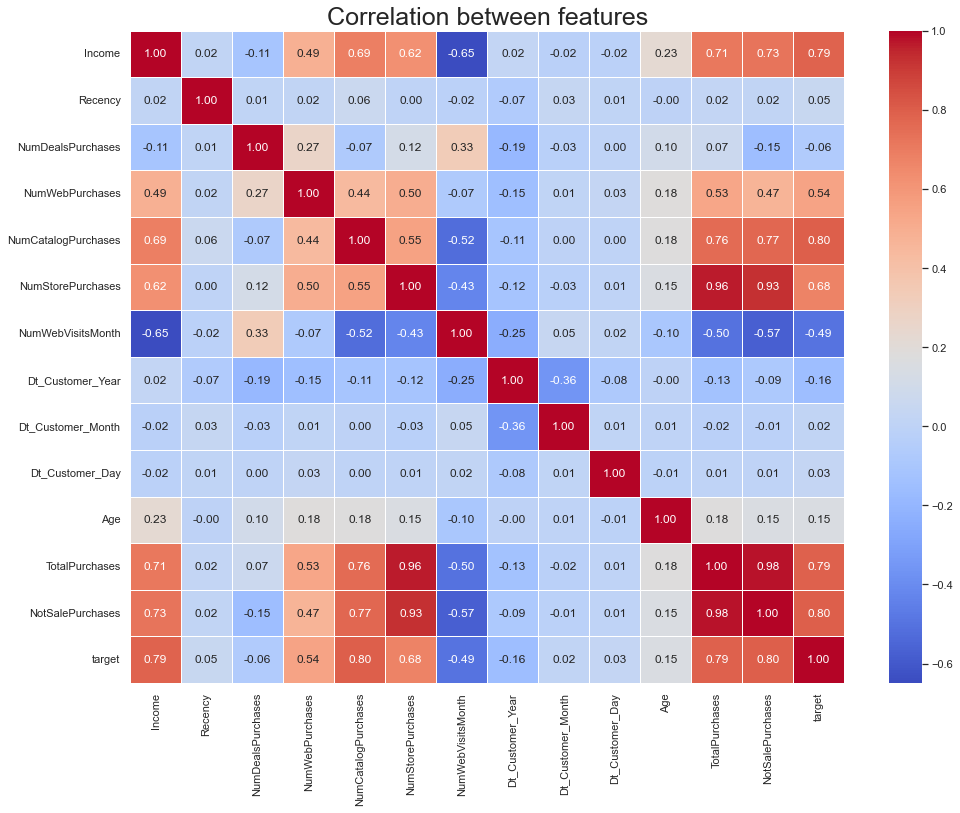

In [112]:
corr_heatmap(df.drop('id', axis=1))

`-` 다중공선성 유의해야 함

`-` 상관행렬 시각화

In [113]:
features = [df.columns[i] for i, dtype in enumerate(df.dtypes) if dtype.name.find('int') != -1 or dtype.name.find('float') != -1] ## 숫자타입만 사용

In [114]:
drop_columns = ['id', 'Age', 'Recency', 'Dt_Customer_Year', 'Dt_Customer_Month', 'Dt_Customer_Day']

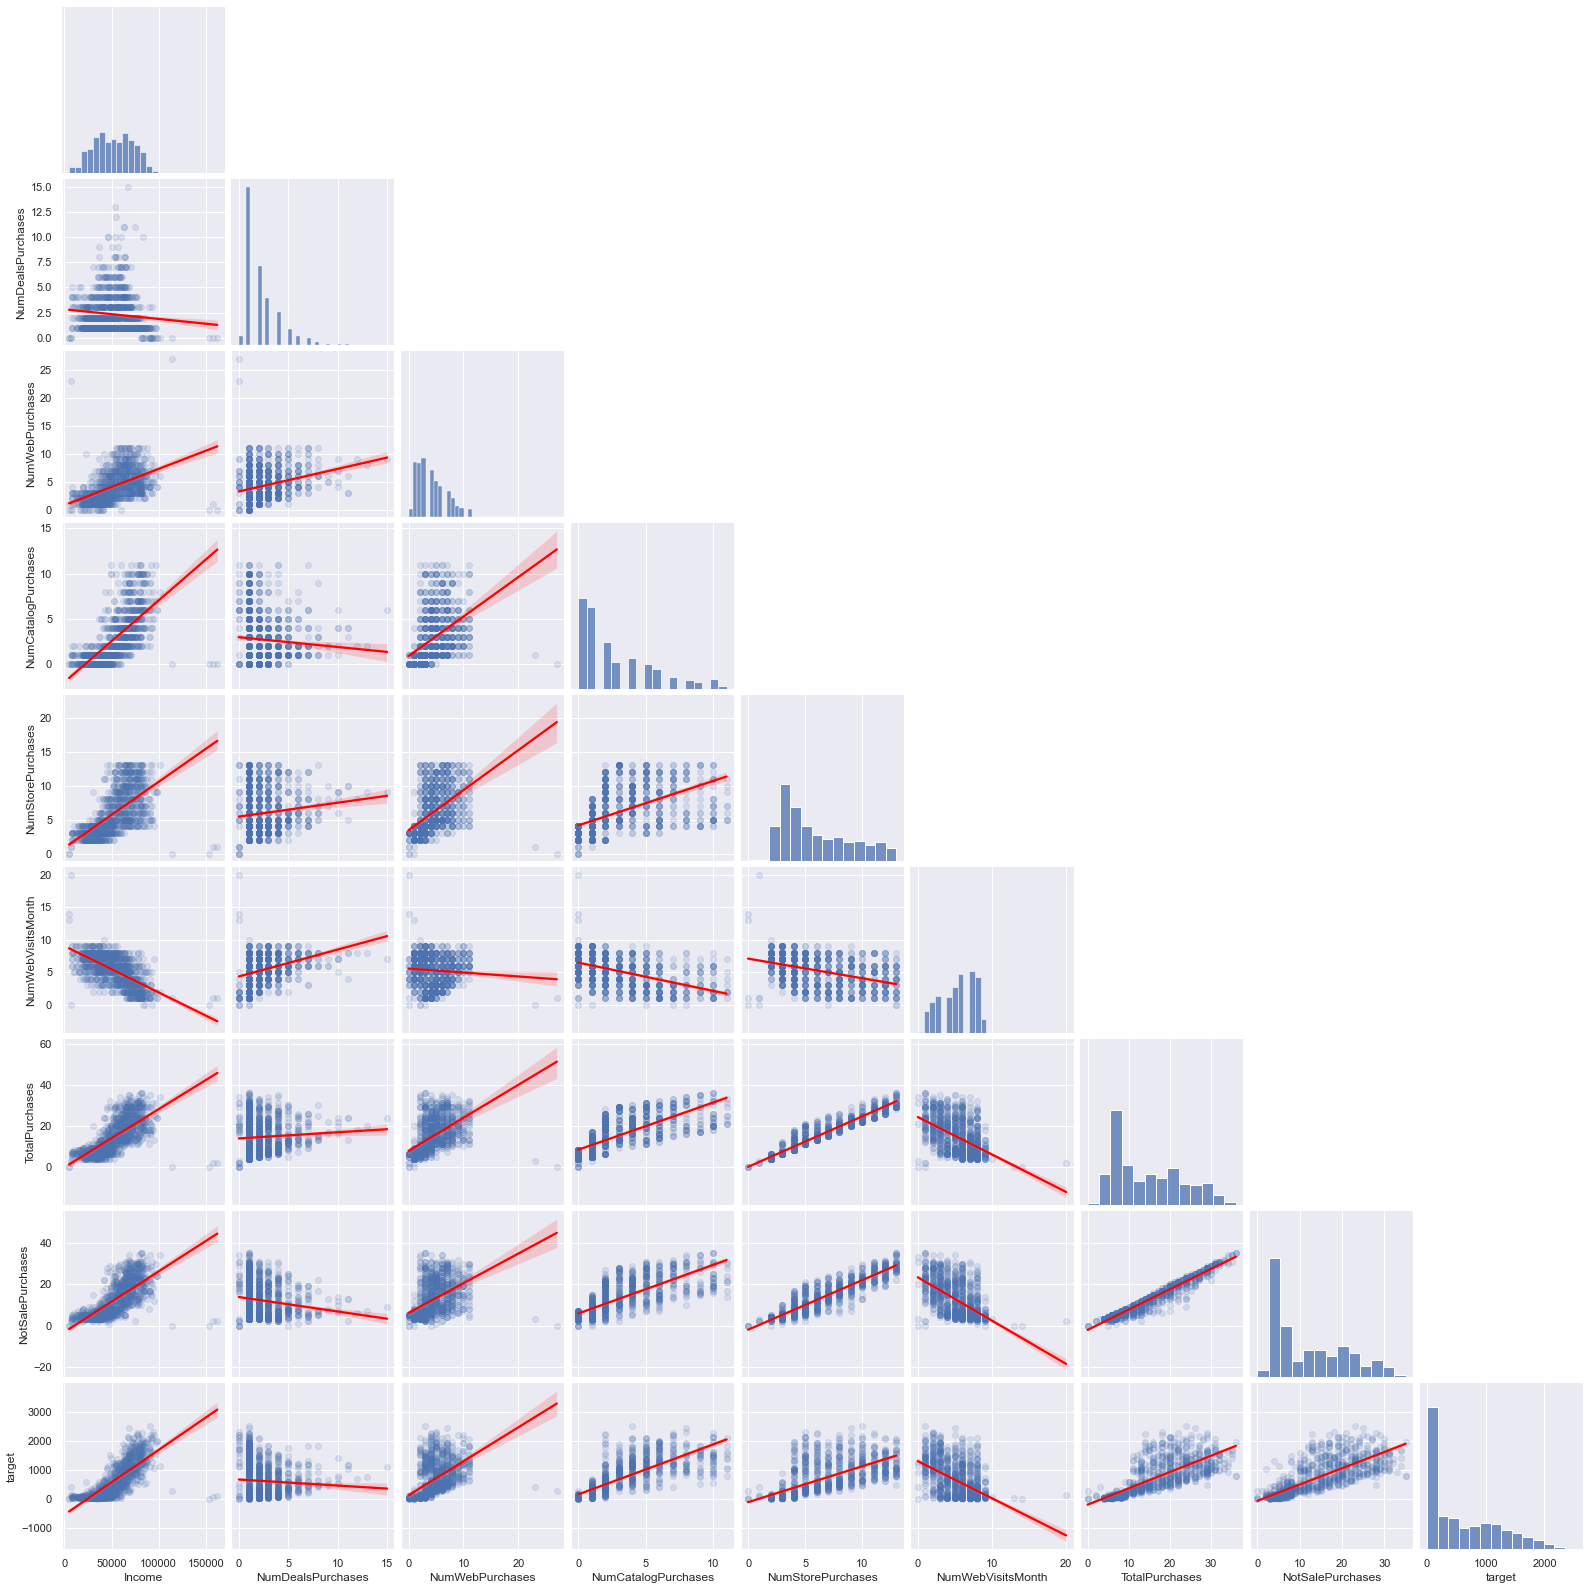

In [115]:
sns.pairplot(data=df,
             kind='reg',
             vars=[feature for feature in features if feature not in drop_columns],
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha':0.15}},
             corner=True)

`-` 전체 양적 변수를 가지고 시각화를 해봤는데 균일분포 성격을 띄는 변수가 있어서 제외하고 다시했다

`-` 위의 plot을 잘 보면 심각한 이상점과 영향점들이 존재한다

`-` 예컨대 `NumWebPurchases`의 경우 20을 넘는 2개의 영향점이 존재

`-` 이를 제거하면 상관계수도 조금 상승한다

`-` 모델링을 할 때 이상점과 영향점들을 제거해야 한다

`-` 또한 `Income` 변수가 가장 유용해보인다

`-` 그런데 웹사이트 방문 횟수가 많아지면 소비가 감소하는데 이유가 제품 환불하려고 웹사이트 들어가서 그런건가?

`-` 아니면 사지는 못하니 눈으로만 많이 보는건가?

`-` 고객의 제품 총 소비량은 환불에는 포함되지 않는게 맞겠지?

`-` 제품 총 소비량이니까 여태까지 쓴 소비량의 합일 것이다

`-` 그러면 회원가입 일자와 같은 변수가 충분히 영향을 끼칠 수 있을 것이다

`-` 그런데 위의 변수들이 범주형 변수의 의해 군집화 되어있을 수도 있다

- 자식의 수

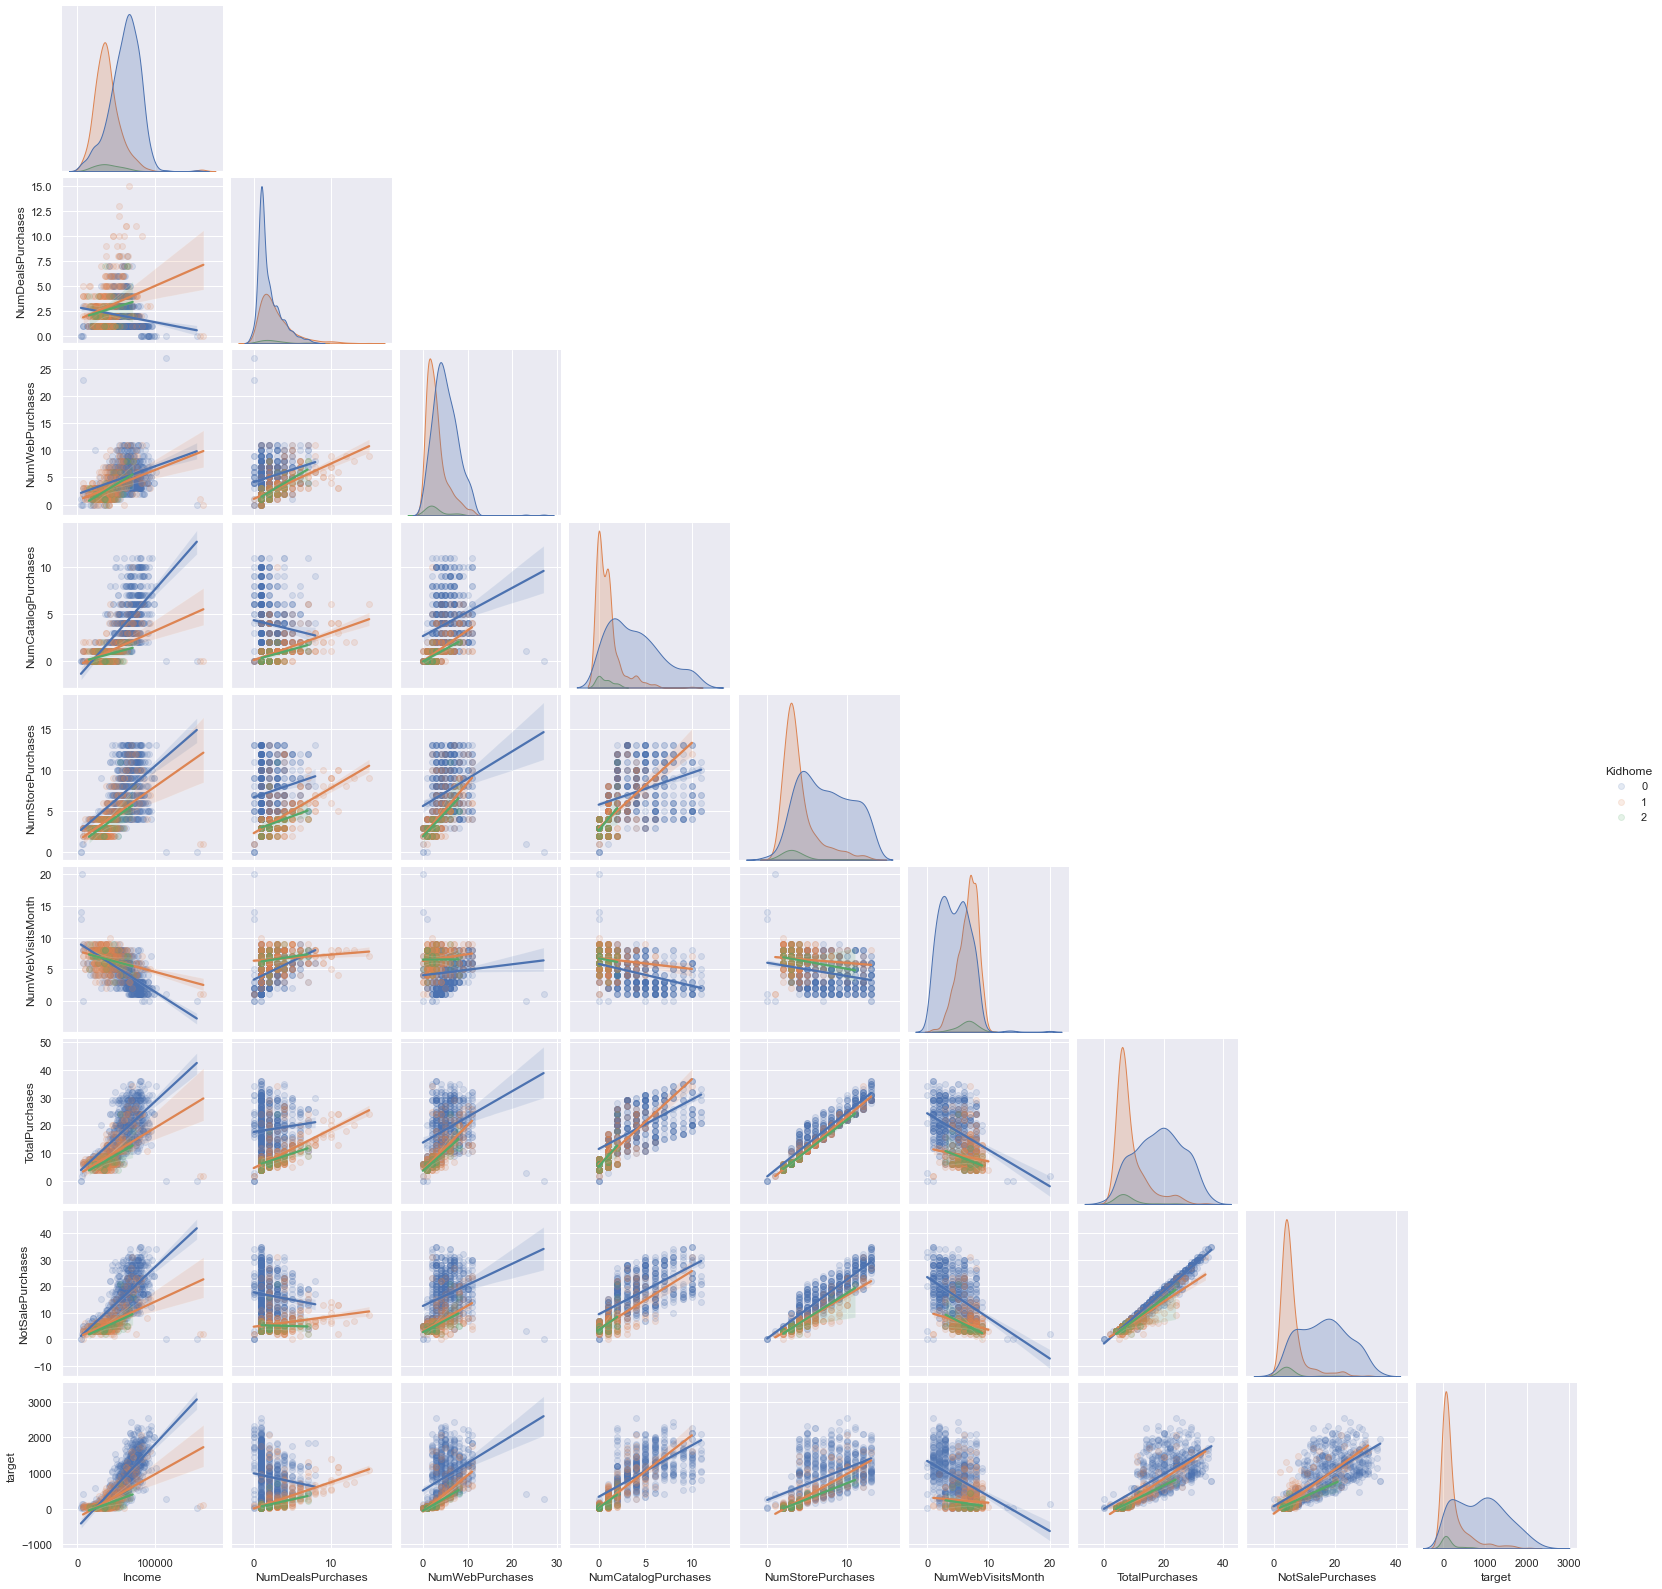

In [116]:
sns.pairplot(data=df,
             kind='reg',
             hue='Kidhome',
             vars=[feature for feature in features if feature not in drop_columns],
             plot_kws={'scatter_kws': {'alpha':0.15}},
             corner=True)

`-` `Response` 변수는 유용하지 않았다

`-` `Kidhome` 변수는 매우 유용해보인다(자식이 0명이냐 1명이냐에 따라 상관계수 부호도 달라지는 변수도 존재)

`-` 자식이 1명이냐 2명이냐는 큰 차이는 없어보인다(하나로 통일해도 될 듯하다)

`-` `Kidhome` 변수를 사용하여 교호작용을 추가할 수 있을 듯하다

- 자식(teen)의 수

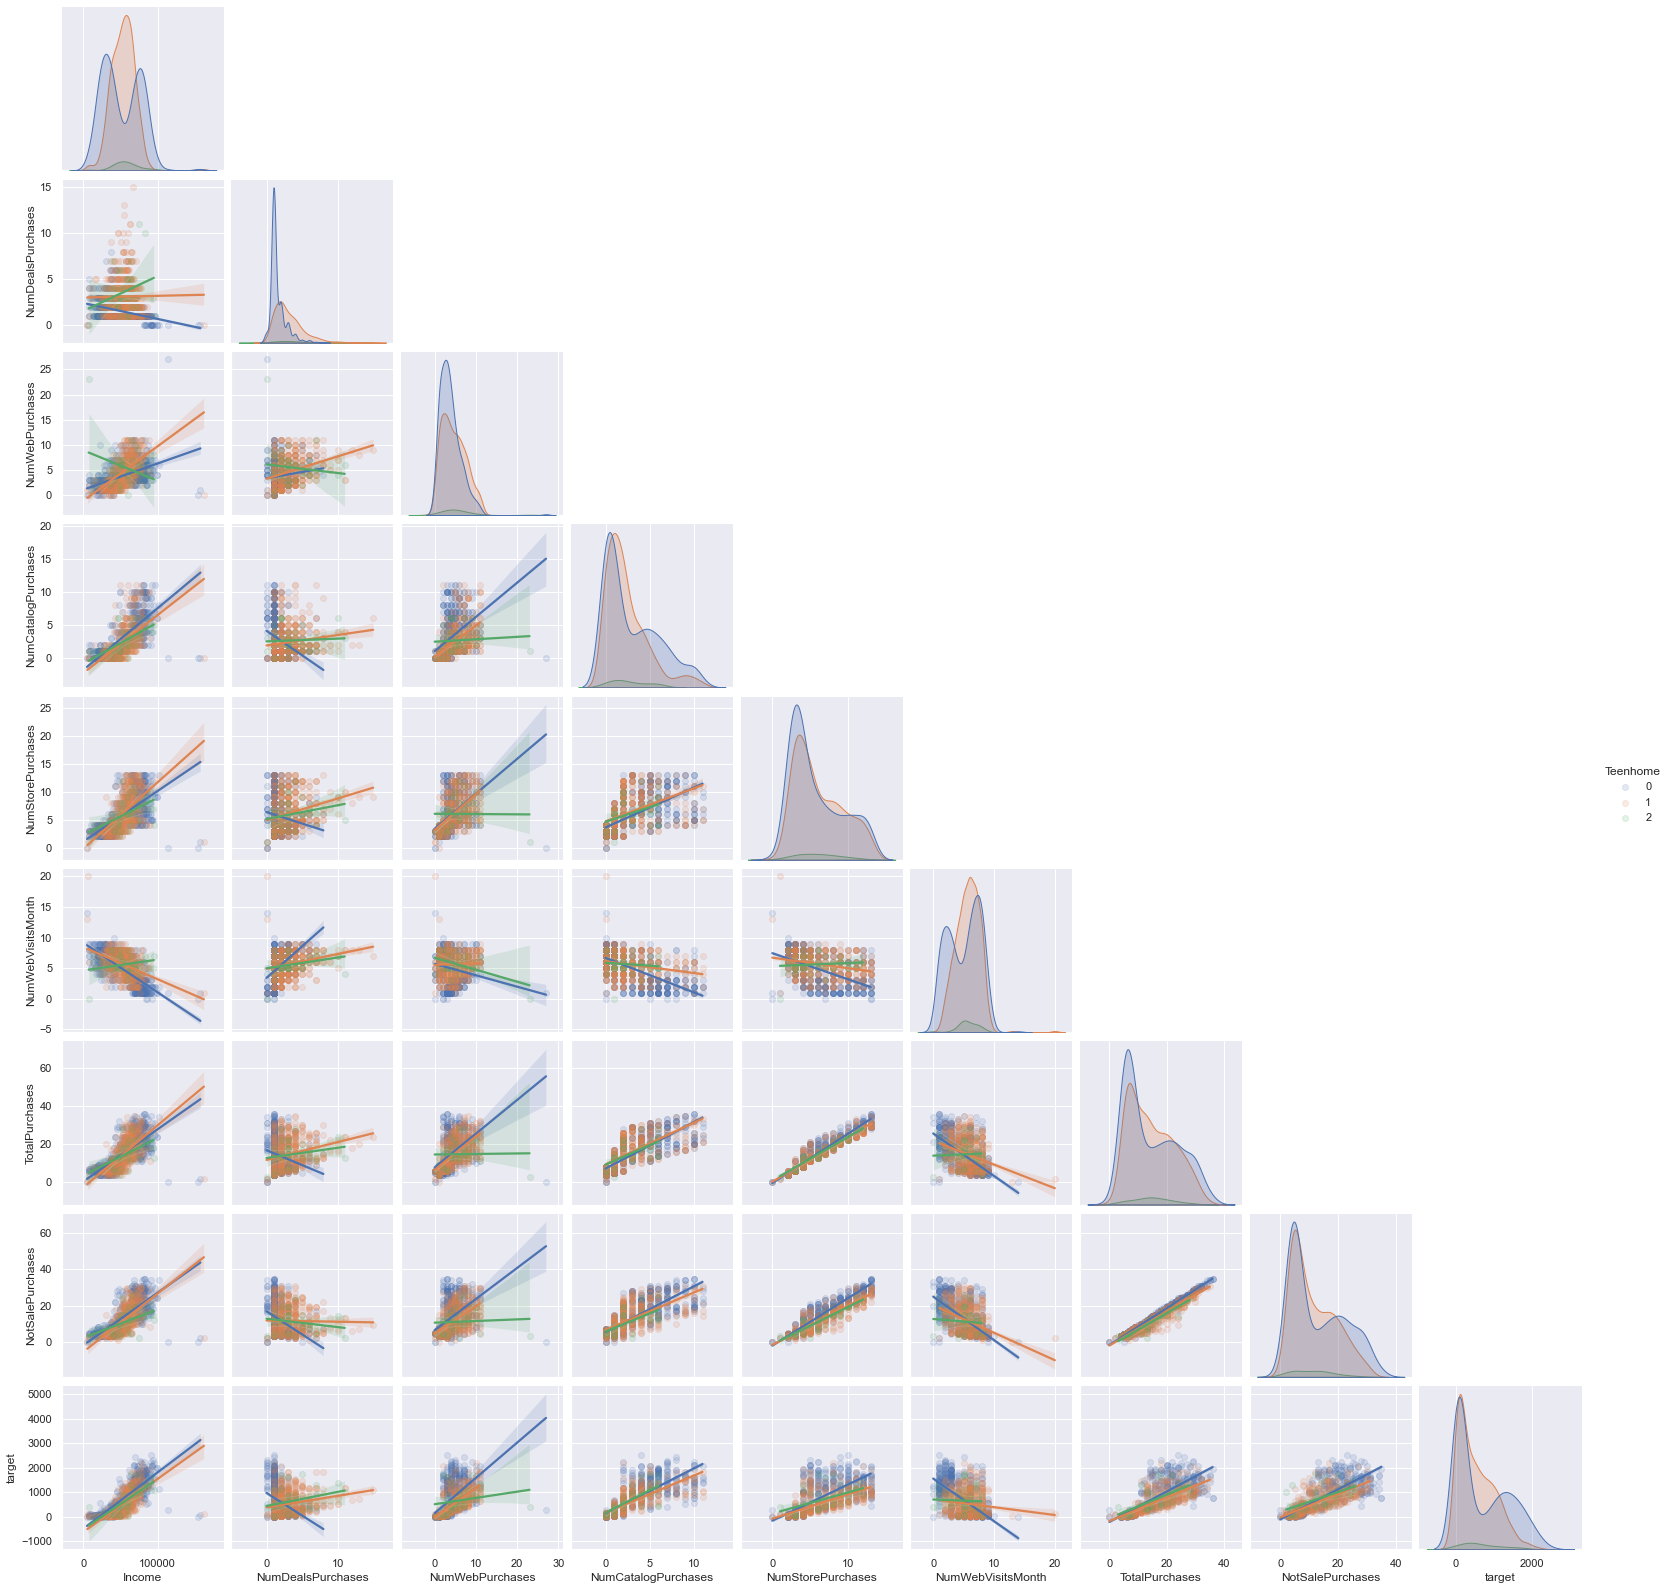

In [117]:
sns.pairplot(data=df,
             kind='reg',
             hue='Teenhome',
             vars=[feature for feature in features if feature not in drop_columns],
             plot_kws={'scatter_kws': {'alpha':0.15}},
             corner=True)

`-` `Teenhome` 변수도 유의해보인다(Kidhome 변수도 유의했으니 당연하다...)

`-` 둘다 쓰는게 좋은지 어느하나만 쓰는게 좋은지는 직접 모델링을 해봐야 정확하겠지만

`-` 내가 보기엔 `Kidhome` 변수만 쓰는 것이 나아보인다

`-` 왜냐하면 target을 예측하는데 있어 `Income`이 제일 중요해보이는데

`-` `Kidhome` 변수는 `Income` 변수와 교호작용이 있어보이지만 `Teenhome` 변수는 그렇지 않기 때문이다

`-` 근데 plot 크기가 작아서 잘 보이지 않으니 제대로 시각화해보자

<AxesSubplot:xlabel='Income', ylabel='target'>

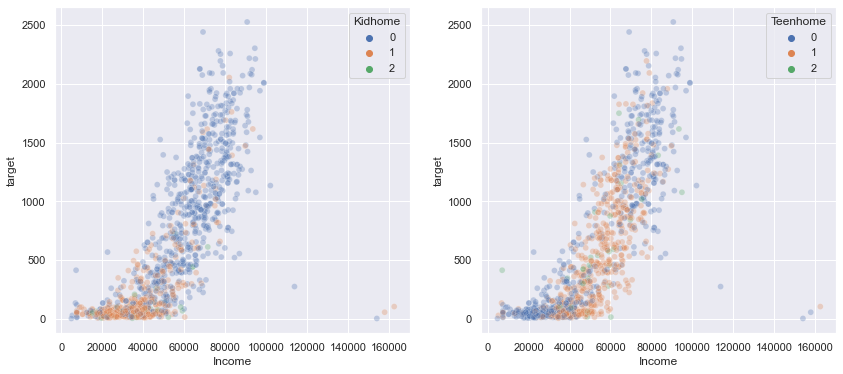

In [150]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(data=df, x='Income', y='target', hue='Kidhome', alpha=0.3, ax=ax1)
sns.scatterplot(data=df, x='Income', y='target', hue='Teenhome', alpha=0.3, ax=ax2)

`-` 오히려 `Teenhome` 변수를 사용하는게 나아보인다

`-` `Kidhome`는 자식이 1명인 경우 target이 $0$ 근처에 너무 많이 몰려있다

- 캠페인 참여 유무(마지막과 3번째 캠페인은 제외)

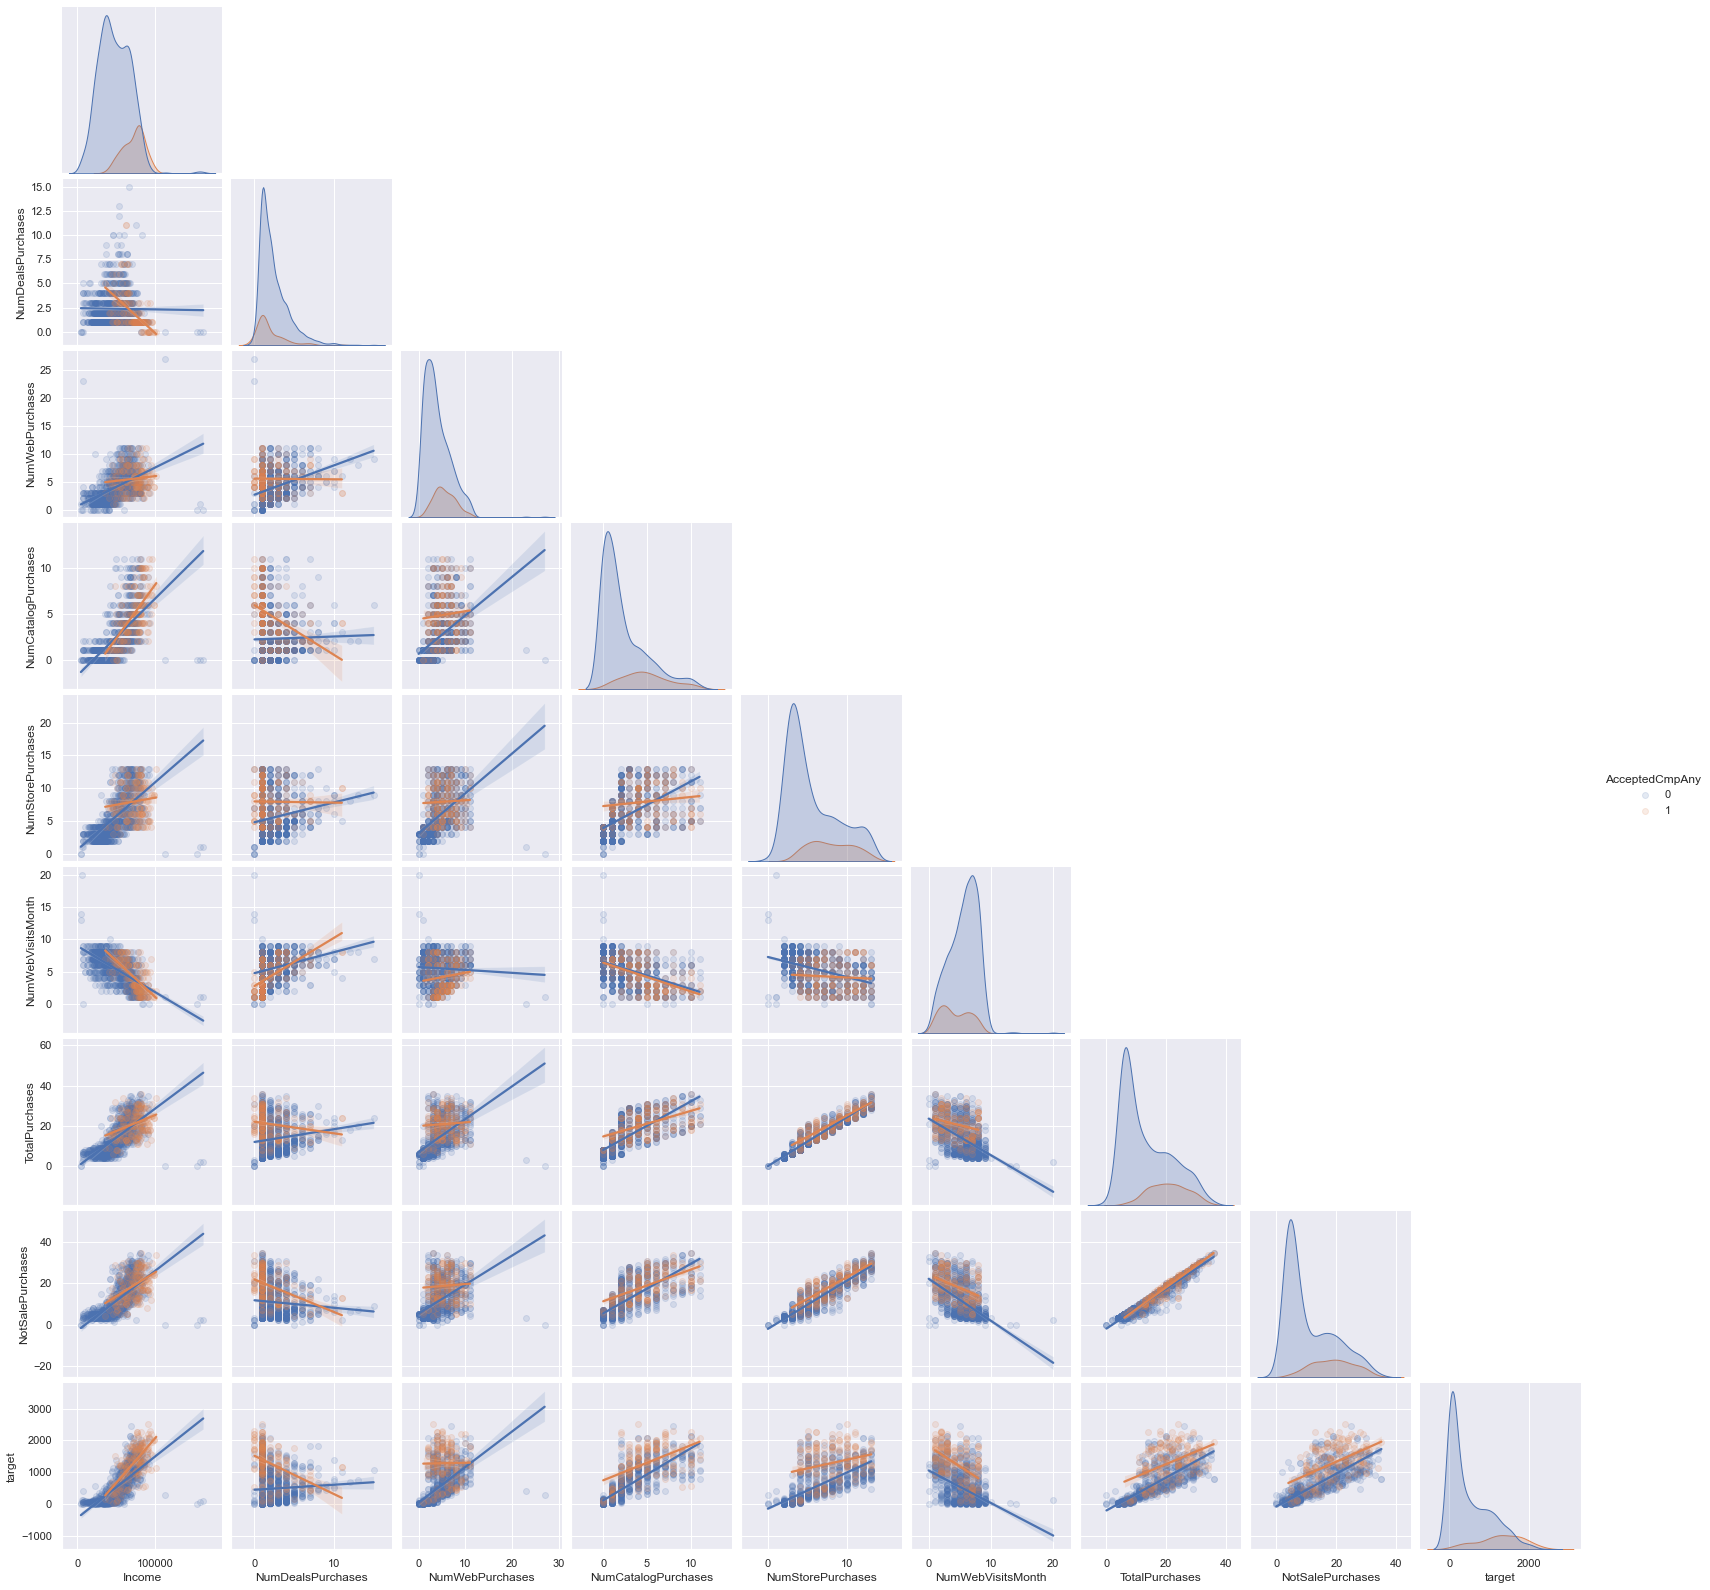

In [120]:
sns.pairplot(data=df,
             kind='reg',
             hue='AcceptedCmpAny',
             vars=[feature for feature in features if feature not in drop_columns],
             plot_kws={'scatter_kws': {'alpha':0.15}},
             corner=True)

`-` 캠페인에 한 번이라도 참여한 사람과 그렇지 않은 사람들간의 차이가 있어 보인다

`-` 혹시 회사에서 특정 기간동안 가입 이벤트를 해서 회원가입을 몇월에 했는지로 나눠서 탐색해봤는데

`-` 유의미한 차이가 없어보였다

`-` 년도와 월을 같이 봐야 정확하긴 한데 딱히 의미없을 듯하다

`-` 몇번째 캠페인을 수락했는지에 따라 차이가 있는지 확인해봤는데 유의한 차이는 없었다

`-` 위의 plot들을 보면 양봉분포가 많이 보이는데 이유는 모르겠다(단일 히스토그램을 보면 양봉분포로 보이지 않는다)

`-` 더 탐구해봐야 할 듯

### target 변수 시각화

<AxesSubplot:>

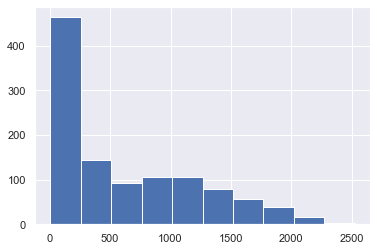

In [232]:
df.target.hist()

<AxesSubplot:>

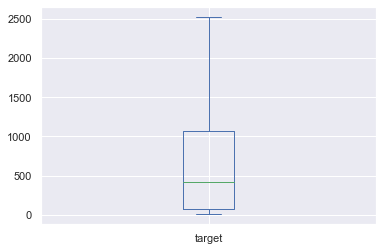

In [233]:
df.target.plot.box()

`-` target의 분포는 오른쪽으로 치우친 분포이다

`-` 근데 이상점은 존재하지 않는다

`-` 위의 plot을 보면 0 근처에 값이 꽤 많아보인다

<AxesSubplot:>

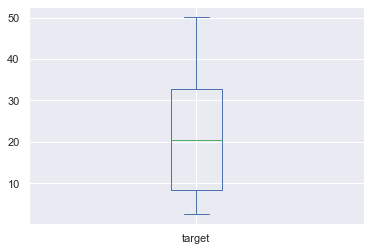

In [510]:
np.sqrt(df.target).plot.box()

`-` target에 제곱근 변환을 해주니 어느정도 대칭인 분포가 되었다

`-` 모델링할 때 제곱근 변환을 사용하겠다

<AxesSubplot:xlabel='Marital_Status', ylabel='target'>

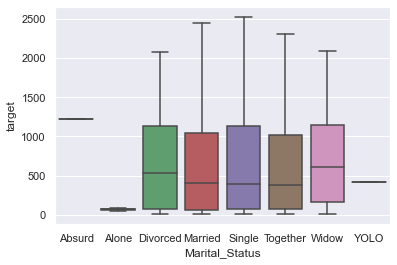

In [34]:
sns.boxplot(data=df, x='Marital_Status', y='target')

`-` 쓸모 없어 보인다

<AxesSubplot:xlabel='Education', ylabel='target'>

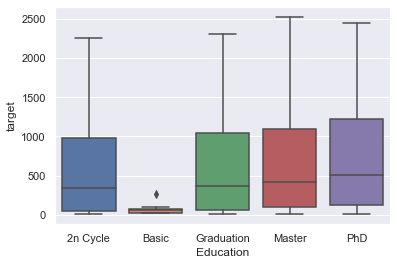

In [236]:
sns.boxplot(data=df, x='Education', y='target')

`-` 쓸모 없어 보인다2

<AxesSubplot:xlabel='Response', ylabel='target'>

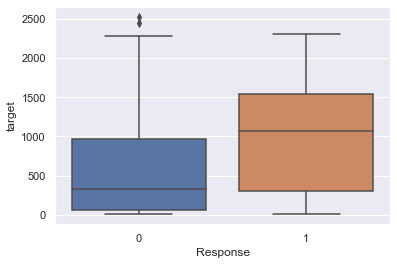

In [237]:
sns.boxplot(data=df, x='Response', y='target')

`-` 위에서 상관관계 시각화 했을 땐 쓸모 없어 보였는데 여기서는 쓸모 있어 보인다

`-` 교호작용은 없고 단순 절편에 영향을 끼치는 것 같다

<AxesSubplot:xlabel='Teenhome', ylabel='target'>

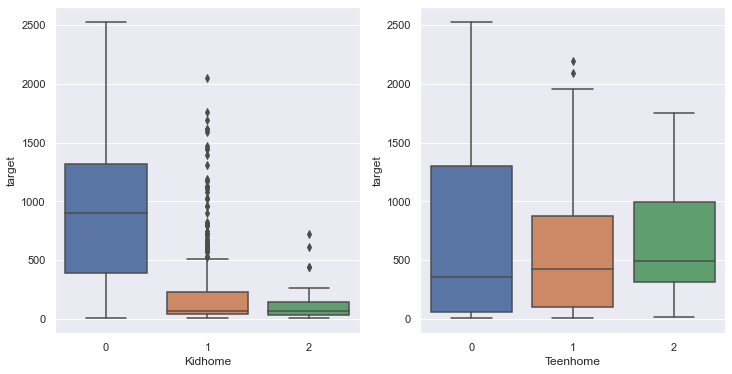

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
sns.boxplot(data=df, x='Kidhome', y='target', ax=ax1)
sns.boxplot(data=df, x='Teenhome', y='target', ax=ax2)

`-` 매우 쓸모 있어 보인다^^

<AxesSubplot:xlabel='Dt_Customer_year', ylabel='target'>

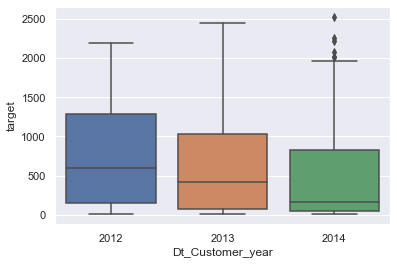

In [238]:
sns.boxplot(data=df, x='Dt_Customer_year', y='target')

`-` 소비는 누적되기 때문에 오래전에 가입한 사람들의 소비량이 많은편이다

`-` 이외의 날짜 관련 변수는 시각화 해보니 쓸모 없어 보였다

`-` `Recency` 변수를 중앙값을 기준으로 범주화시켜서 시각화해봤는데 무쓸모였다

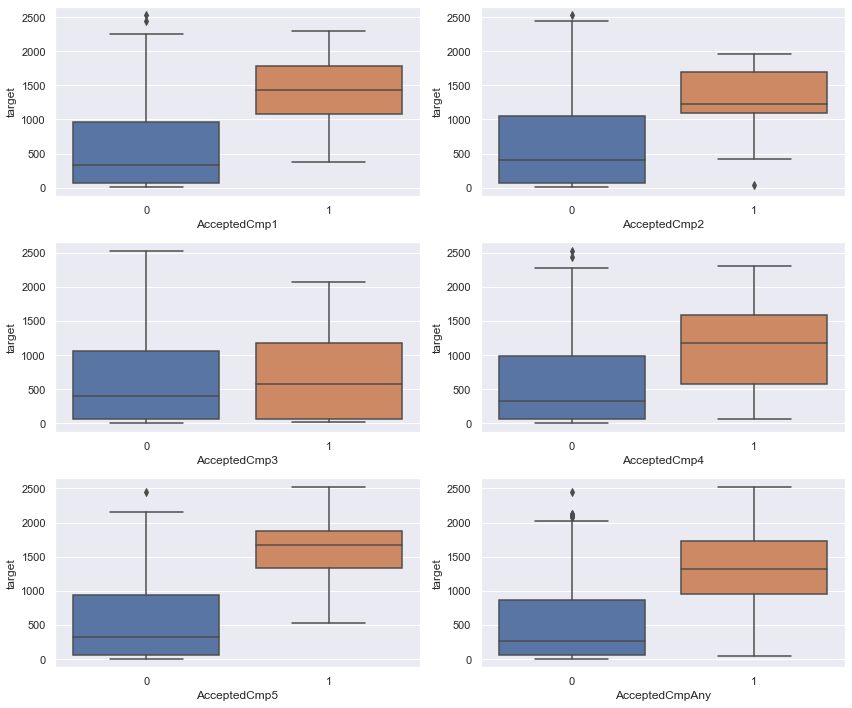

In [127]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
for i, ax in enumerate(axs.flatten()):
    features = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmpAny']
    sns.boxplot(data=df, x=features[i], y='target', ax=ax)
fig.tight_layout()

`-` 캠페인을 몇번째에 수락했느냐에 따라 소비량에 차이가 있다

`-` `AcceptedCmp3` 변수의 경우 제안을 수락했든 안했든 소비량에 차이가 없다

`-` `AcceptedCmp_any` 변수를 다시 수정해야 겠다(3번째 캠페인은 제외했다)

## 모델링

### 인코딩 및 이상점 제거

`-` 캠페인 참여와 관련된 변수는 `AcceptedCmpAny`와 `Response` 변수만 사용하겠다

`-` 날짜 관련 변수는 `Dt_Customer_Year` 변수만 사용하겠다(현재 연도와의 차이로 바꾸어 사용하겠다) 

`-` 이외의 날짜 관련 변수는 target과 관련이 없어보여서 사용하지 않겠다

`-` `Education` 변수와 `Marital_Status` 변수는 target과 관련이 없어보여 사용하지 않겠다

`-` `Complain` 변수는 불만을 가진 고객이 10명으로 너무 적어 사용하지 않겠다

`-` 다중공선성 문제로 `Teenhome` 변수를 사용하고 `Kidhome` 변수는 사용하지 않겠다(이럴려고 했는데 둘 다 쓰기로 했다)

`-` `Teenhome` 변수에서 자식이 2명이 경우는 매우 적어 1명이 경우와 통합하겠다(`Kidhome`도 마찬가지)

`-` 위에서 확인한 상관관계 히트맵을 통해 `Income`, `NumWebVisitsMonth` 변수와 `Teenhome` 변수간의 교호작용을 추가하겠다

`-` 또한 `NumDealsPurchases` 변수와 `Kidhome` 변수간의 교호작용을 추가하겠다(이외는 다중공선성 문제로 안하기로 했다)

`-` 구매 횟수 관련 변수는 다중공선성 문제로 설명변수간의 상관계수가 낮은 변수들만 사용하겠다

In [725]:
df['Dt_Customer_Year'] = df['Dt_Customer_Year'].map({2014:0, 2013:1, 2012:0})
test['Dt_Customer_Year'] = test['Dt_Customer_Year'].map({2014:0, 2013:1, 2012:0})

In [726]:
to_int(df)
to_int(test)

In [727]:
df['Teenhome'] = df['Teenhome'].apply(lambda x: 1 if x == 2 else x)
test['Teenhome'] = test['Teenhome'].apply(lambda x: 1 if x == 2 else x)

df['Kidhome'] = df['Kidhome'].apply(lambda x: 1 if x == 2 else x)
test['Kidhome'] = test['Kidhome'].apply(lambda x: 1 if x == 2 else x)

In [728]:
def add_interaction(df_) -> pd.DataFrame:
    df = df_.copy()
    ## Teenhome
    for feature in ['Income', 'NumWebVisitsMonth']:
        df[f'Teenhome_{feature}'] = df['Teenhome'] * df[feature]    
    
#     ## AcceptedCmp_any
#     for feature in ['NumWebPurchases']:
#         df[f'AcceptedCmpAny_{feature}'] = df['AcceptedCmpAny'] * df[feature]

    ## Kidhome
    df['Kidhome_NumDealsPurchases'] = df['Kidhome'] * df['NumDealsPurchases']
        
    return df

In [729]:
df = add_interaction(df)
test = add_interaction(test)

- 이상점 제거

`-` 위에서 수행한 시각화를 바탕으로 이상점을 제거하겠다

`-` `Income` 110000 이상인 경우 제거

`-` `NumWebPurchases` 20 이상인 경우 제거

`-` `NumWebVisitsMonth` 11 이상인 경우 제거

In [730]:
df = df.query('Income < 110000 and NumWebPurchases < 20 and NumWebVisitsMonth < 11').reset_index().drop('index', axis=1)

### 모델 생성 및 학습

In [948]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [732]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true - pred))
    score = mae / np.mean(np.abs(true))
    return score

`-` NMAE 평가방식의 경우 큰 값을 잘 맞춰야 이득이다

In [733]:
true = np.array([100, 1000])
pred = np.array([90, 900])
NMAE(true, pred)

0.1

In [337]:
true1 = np.array([100, 1000])
pred1 = np.array([100, 900])
true2 = np.array([100, 1000])
pred2 = np.array([90, 1000])
NMAE(true1, pred1), NMAE(true2, pred2)

(0.09090909090909091, 0.00909090909090909)

`-` 10배 차이나 난다...

In [338]:
true3 = np.array([100, 1000])
pred3 = np.array([100, 900])
pred3_over = np.array([100*1.1, 900*1.1])
NMAE(true3, pred3), NMAE(true3, pred3_over)

(0.09090909090909091, 0.01818181818181809)

`-` 만약 큰 값을 작게 추정한다면 상수를 곱해서 크게 만드는 것이 이득이다

In [963]:
def OOF_predict(model, X, y, test, SKfold, stratify):
    """
    Out-Of-Fold 방식을 통해 test(numeric)를 예측
    train, valid에 대한 NMAE score와 예측한 test를 return
    """ 
    model_train_score = []
    model_valid_score = []
    model_pred = np.zeros(shape=(test.shape[0]))

    for i, (train_idx, valid_idx) in enumerate(SKfold.split(X, X[stratify])):
        # print(f'({i + 1} / {SKfold.n_splits}) Fold Training......')
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        X_valid, y_valid = X.iloc[valid_idx], y[valid_idx]
        
        ## target에 제곱근 변환
        y_train = np.sqrt(y_train)
        
        ## 모델 적합
        model.fit(X_train, y_train)
        
        ## prediction
        train_pred = model.predict(X_train) ## train
        valid_pred = model.predict(X_valid) ## valid
        test_pred = model.predict(test) ## test
        
        model_train_score.append(NMAE(np.square(y_train), np.square(train_pred))) ## train NMAE
        model_valid_score.append(NMAE(y_valid, np.square(valid_pred))) ## valid NMAE
        model_pred += np.square(test_pred) / SKfold.n_splits ## test 예측값(k Fold)
              
    return model_train_score, model_valid_score, model_pred

In [980]:
def ensemble_model(model_list, X, y, test, SKfold, stratify):
    """
    모델을 앙상블하여 test(numeric)를 예측
    예측한 test를 return
    """
    test_ensemble_pred = np.zeros(shape=(test.shape[0]))
    for model in tqdm(model_list):
        _, _, test_pred = OOF_predict(model, X, y, test, SKfold, stratify)
        test_ensemble_pred += test_pred / len(model_list)
        
    return test_ensemble_pred

`-` feature selection은 위에서 말한대로 진행한다

In [735]:
# df['Education'] = df['Education'].map({'PhD':3, 'Master':2, 'Graduation':1, '2n Cycle':0, 'Basic':0}) 
# test['Education'] = test['Education'].map({'PhD':3, 'Master':2, 'Graduation':1, '2n Cycle':0, 'Basic':0}) 
#
# df['Marital_Status'] = df['Marital_Status'].map({'Married':3, 'Together':2, 'Single':1, 
#                                                  'Divorced':0, 'Widow':0, 'Alone':0,
#                                                  'Absurd':0, 'YOLO':0})
#
# test['Marital_Status'] = test['Marital_Status'].map({'Married':3, 'Together':2, 'Single':1, 
#                                                      'Divorced':0, 'Widow':0, 'Alone':0,
#                                                      'Absurd':0, 'YOLO':0})

In [736]:
features = [
            'Income', 'Teenhome', 'Kidhome',
            'NumDealsPurchases', 
            'NumCatalogPurchases',
            #'NumStorePurchases', 
            'TotalPurchases',
            'NumWebPurchases',
            'NumWebVisitsMonth', 
            #'NotSalePurchases',
            'AcceptedCmpAny', 'Response', 'Dt_Customer_Year'
           ]

interaction_features = ['Teenhome_Income',
                        'Kidhome_NumDealsPurchases',
                        'Teenhome_NumWebVisitsMonth',
                        #'AcceptedCmpAny_NumWebPurchases'
                       ]

In [737]:
target = df['target']
df.drop('target', axis=1, inplace=True)

In [738]:
df2 = df[features] ## 교호작용 X
test2 = test[features]

In [739]:
df3 = df[features + interaction_features] ## 교호작용 O
test3 = test[features + interaction_features]

In [975]:
k = 10
skfold1 = StratifiedKFold(k, shuffle=True, random_state=SEED+2)
skfold2 = StratifiedKFold(k, shuffle=True, random_state=SEED**2)

`-` `Teenhome` 변수로 교호작용도 만든만큼 잘 섞여야 하므로 `StratifiedKFold` 사용

In [940]:
RF = RandomForestRegressor(n_estimators=700,
                           max_depth=13,
                           min_samples_split=3,
                           random_state=SEED)

EXT = ExtraTreesRegressor(n_estimators=700,
                          max_depth=18,
                          min_samples_split=3,
                          random_state=SEED)

GD = GradientBoostingRegressor(n_estimators=500,
                               learning_rate=0.03,
                               max_depth=5,
                               min_samples_split=4,
                               random_state=SEED)

CB = CatBoostRegressor(n_estimators=700,
                       learning_rate=0.05,
                       max_depth=8,
                       random_state=SEED,
                       verbose=0)

XGB = XGBRegressor(n_estimators=650,
                   learning_rate=0.05,
                   max_depth=6,
                   random_state=SEED)

`-` 개별 모델에 대한 성능을 파악하고 싶으면 `OOF_predict` 함수만 사용하면 된다

In [976]:
model_list = [RF, EXT, GD, CB, XGB]

In [981]:
test_pred1 = ensemble_model(model_list, df3, target, test3, skfold1, stratify='Teenhome')
test_pred2 = ensemble_model(model_list, df3, target, test3, skfold2, stratify='Teenhome')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:52<00:00, 22.51s/it]


`-` 위에 코드도 함수로 만들어서 간편하게 해야겠다

### submission

In [1075]:
submission['target'] = (test_pred1 + test_pred2) / 2
submission.head()

,id,target
0,0,502.875698
1,1,595.099975
2,2,807.418435
3,3,1234.476978
4,4,1201.144591


In [1037]:
submission.to_csv('./Data/submission2.csv', index=False)

### 데이터 후처리

`-` 소비량을 실제값보다 더 작게 예측하는 경향이 있어 적당한 상수를 곱해주겠다

`-` 또한, 소비량은 정수이므로 반올림을 해주겠다

In [1076]:
idx1 = np.where(submission['target'] < 422)
idx2 = np.where(submission['target'] > 1000)

In [1077]:
submission['target'].loc[idx1] = 1.05 * submission['target'].loc[idx1]
submission['target'].loc[idx2] = 1.05 * submission['target'].loc[idx2]
submission.head()

,id,target
0,0,502.875698
1,1,595.099975
2,2,807.418435
3,3,1296.200827
4,4,1261.201820


In [1078]:
submission.to_csv('./Data/submission_2round.csv', index=False)